<a href="https://colab.research.google.com/github/kejjhmi/kejjhmi/blob/main/ml_intro_pred_maintenance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Introduction to AI & ML**
### *Michaela Buchanan - Mark III Systems*

If you would like to see some more examples using these algorithms, there is are two other versions of this notebook available. One focuses on predicting car prices and the other looks at determining if tumors are malignant or benign. See the links below to check them out.


**Car price prediction:**

https://colab.research.google.com/drive/1-7g2CRQinW_ytjZvJbOd74vnqu4OAdoL?usp=sharing

**Tumor classification:**

https://colab.research.google.com/drive/1SOhm2tqj62hb8GmLPJw6LhE5BFnpePXn?usp=sharing

---

Imports for all the code below. Please run first before anything else!

In [ ]:
!git clone https://github.com/michaelabuchanan/ml_workshop.git
!pip install pycm==3.7
import sys

# data preprocessing
import pandas as pd
import numpy as np
import matplotlib
from sklearn.model_selection import train_test_split

# logistic regression
from matplotlib import pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from pycm import ConfusionMatrix
import cv2

# random forest
from sklearn import tree, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# xgboost
from xgboost import XGBClassifier

print(sys.version)

fatal: destination path 'ml_workshop' already exists and is not an empty directory.
3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]




---

###Introduction


This workshop will be showing both the workflow of a typical ML project as well as demonstrating a few common models. We will be following the ML Project lifecycle mentioned in the previous lecture and covering linear regression, decision trees, random forest, and XGBoost models.

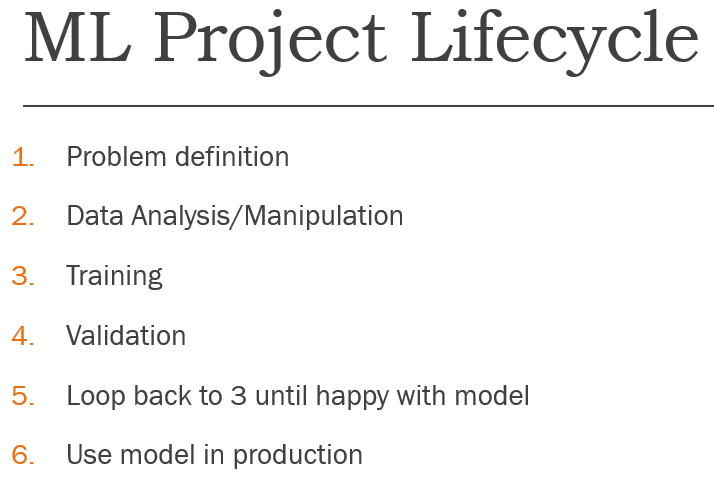

In this notebook we will be looking at a synthetic dataset that "reflects real predictive maintenance encountered in the industry". [Click here](https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset) to see the source for this dataset. We will be trying to predict the conditions that cause a machine to fail based on factors like tool wear, torque, rpm, and temperature.


---

###Problem Definition


Predict conditions that will produce a failure in the operation of a machine.



---

### Data Analysis/Preprocessing


The first step we need to take is to look at our data. In the first cell you ran, you cloned a GitHub repo which contained the `pred_maintenance.csv` file. A few rows of this file are shown below.

In [ ]:
data = pd.read_csv('./ml_workshop/pred_maintenance.csv', index_col="UDI")
data

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
UDI,,,,,,,,,,,,,
1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0


First let's check out what datatypes we have in our dataset. If the data types are not what we expect, we could run into problems with our preprocessing and later on with our training.

In [ ]:
data.dtypes

Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object

In general, you can't provide text input to a ML model. This is a problem since two of our categories (Product ID and Type) are text based as shown by their `object` data type above. Luckily, it is pretty easy with Numpy to turn all this text into numbers which we will see in a little bit. We are only going to do this for Type as the Product ID column just restates inforation already available in the other columns so we will be removing it using the `pop` command. We are also going to remove the failure type columns as we are only interested in predicting failure in general, not by type, for this problem.

In [ ]:
# categorical columns
data.pop('Product ID')
product_type = data.pop('Type')

# failure type columns
data.pop('TWF')
data.pop('HDF')
data.pop('PWF')
data.pop('OSF')
data.pop('RNF')

print("Done")

Done


Here we check our work and see that the only columns left in data are numerical.

In [ ]:
data

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
UDI,,,,,,
1,298.1,308.6,1551,42.8,0,0
2,298.2,308.7,1408,46.3,3,0
3,298.1,308.5,1498,49.4,5,0
4,298.2,308.6,1433,39.5,7,0
5,298.2,308.7,1408,40.0,9,0
...,...,...,...,...,...,...
9996,298.8,308.4,1604,29.5,14,0
9997,298.9,308.4,1632,31.8,17,0
9998,299.0,308.6,1645,33.4,22,0


Now let's perform our one-hot encoding for the one categorical column that we are interested in keeping.

In [ ]:
oh_type = pd.get_dummies(product_type)

print("Done")

Done


And finally we reappend these new one-hot encoded column back onto our original dataframe

In [ ]:
processed_data = pd.concat([data, oh_type], axis=1)
processed_data

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,H,L,M
UDI,,,,,,,,,
1,298.1,308.6,1551,42.8,0,0,0,0,1
2,298.2,308.7,1408,46.3,3,0,0,1,0
3,298.1,308.5,1498,49.4,5,0,0,1,0
4,298.2,308.6,1433,39.5,7,0,0,1,0
5,298.2,308.7,1408,40.0,9,0,0,1,0
...,...,...,...,...,...,...,...,...,...
9996,298.8,308.4,1604,29.5,14,0,0,0,1
9997,298.9,308.4,1632,31.8,17,0,1,0,0
9998,299.0,308.6,1645,33.4,22,0,0,0,1


One last thing to check before we train. If any of the values are missing in our dataset, they will be listed as NaN (not a number) in our dataframe. When we go to train, our algorithm won't know what to do with these values so we are going to go ahead and remove any rows with missing values now. We should also check for and remove any duplicated columns as well.

In [ ]:
processed_data.dropna(inplace=True)
processed_data = processed_data.loc[:,~processed_data.columns.duplicated()]
processed_data

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,H,L,M
UDI,,,,,,,,,
1,298.1,308.6,1551,42.8,0,0,0,0,1
2,298.2,308.7,1408,46.3,3,0,0,1,0
3,298.1,308.5,1498,49.4,5,0,0,1,0
4,298.2,308.6,1433,39.5,7,0,0,1,0
5,298.2,308.7,1408,40.0,9,0,0,1,0
...,...,...,...,...,...,...,...,...,...
9996,298.8,308.4,1604,29.5,14,0,0,0,1
9997,298.9,308.4,1632,31.8,17,0,1,0,0
9998,299.0,308.6,1645,33.4,22,0,0,0,1




---

###Single Variable Logistic Regression

While we could spend much more time going through our data to make it easier to train off of,  I'm going to move on to training using logistic regression due to time constraints for this session. Logistical regression is very similar to linear regression with the main difference being that we get a categorical output rather than a continuous one. This is what we need to be able to classify into our `0` (no failure) and `1` (failure) categories for the `Machine failure` column. To make things simpler we will be starting off with just one variable to make our predictions which means we need to be able to choose the best column from our dataset to use. The code below creates a graph of the distribution of our two categories among data entries in different columns in our dataset. The columns we are testing are listed in the `test_columns` list. Feel free to change which columns are being used to see if you can find one that fits our task even better than the ones used below.

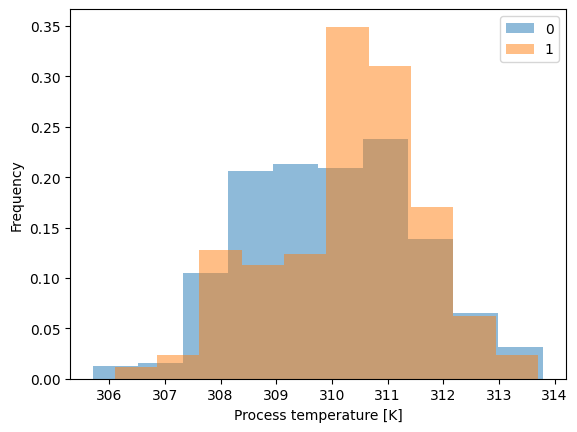

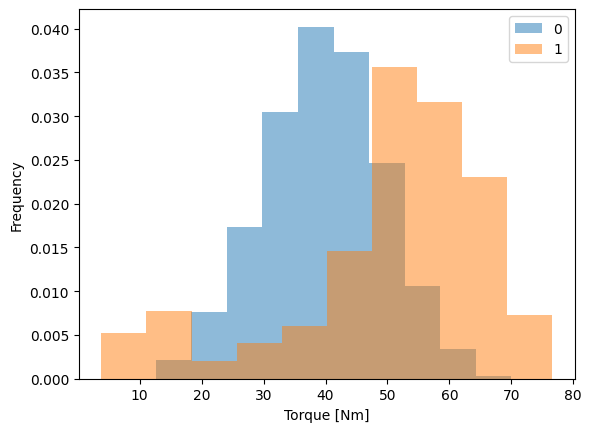

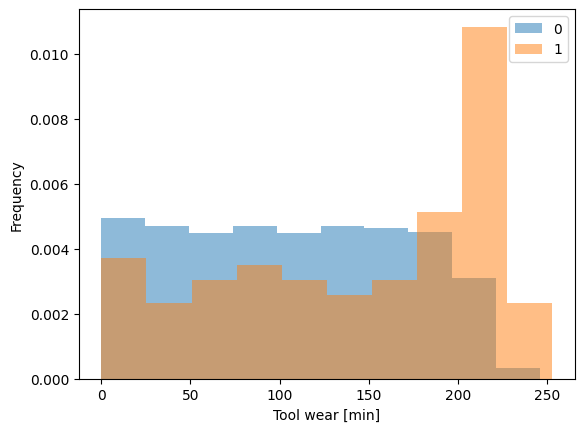

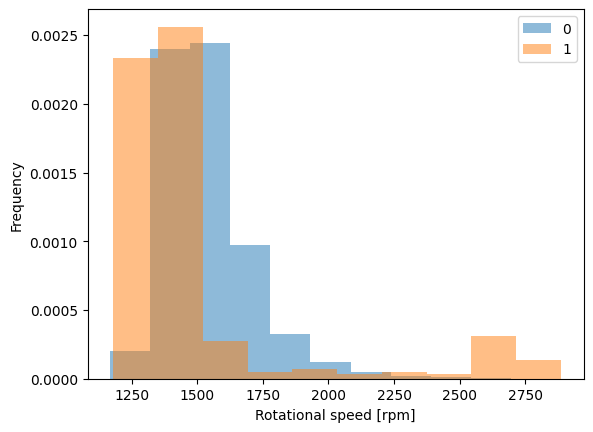

In [ ]:
test_columns = ["Process temperature [K]", "Torque [Nm]", "Tool wear [min]", "Rotational speed [rpm]"]

for feature_name in test_columns:
  plt.figure()
  processed_data.groupby("Machine failure")[feature_name].plot.hist(alpha=0.5, density=True, legend=True)
  plt.xlabel(feature_name)

In these plots we are looking for a clear distinction between where the machine fails and where it doesn't. This would tell us that the feature we are looking at is a good indicator of machine failure. In the graphs shown there are some that look slightly better than others but if you want a better example of what to look for in these graphs check out the tumor classification notebook linked at the top of the page. We can see however that process temperature does not look like a good indicator while torque is the most promising looking option. Now let's run an example of our logistic regression model. We will start by using Process Temperature as our feature to predict Machine failure off of. We will them create the same model using Torque as our feature to see if that increases accuracy.

In [ ]:
# feel free to play with different features to use for X, ie tool wear, air temp, etc
x_single = processed_data['Process temperature [K]']
y_single = processed_data['Machine failure']

# some of this code comes from https://pythonspot.com/linear-regression/

x_single = x_single.values.reshape(len(x_single),1)
y_single = y_single.values.reshape(len(y_single),1)

# Split the data into training/testing sets
x_single_train = x_single[:-500]
x_single_test = x_single[-500:]

# Split the targets into training/testing sets
y_single_train = y_single[:-500]
y_single_test = y_single[-500:]

# Create logistic regression object
temp_model = LogisticRegression()

# Train the model using the training sets
temp_model.fit(x_single_train, y_single_train)
accuracy = temp_model.score(x_single_test, y_single_test)
print(f"Accuracy on test set: {accuracy:.3f}")

Accuracy on test set: 0.974


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The code cell above fetches our `Torque` values as our X and our `Machine Failure` labels as our Y. Then we split our data into training and testing sets and train a Logistic Regression model off this data using `scikit-learn` and the `fit()` function. You should see a test set accuracy value printed out at the end which gives us an indication of this model's performance. Keep this accuracy in mind as we will use it for comparison next. Let's try doing the same thing but using `Rotational Speed` as our X feature.

In [ ]:
# feel free to play with different features to use for X, ie tool wear, air temp, etc
x_single = processed_data['Torque [Nm]']

# some of this code comes from https://pythonspot.com/linear-regression/
x_single = x_single.values.reshape(len(x_single),1)

# Split the data into training/testing sets
x_single_train = x_single[:-500]
x_single_test = x_single[-500:]

# Create logistic regression object
torque_model = LogisticRegression()

# Train the model using the training sets
torque_model.fit(x_single_train, y_single_train)
accuracy = torque_model.score(x_single_test, y_single_test)
print(f"Accuracy on test set: {accuracy:.3f}")

Accuracy on test set: 0.974


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


An important part of data science is being able to tell when things seem a bit "fishy" as a lot of times there's another factor at play scewing your model results. The fact that we got the same exact accuracy from both of these models while using different X features is very unusual and should raise some red flags about the approach we are using.



---



###Dealing with Class Imbalance


If we think a bit more about our dataset itself we start to find a big problem. When we record data points of an industrial machine in operation at set increments, most of these values are going to report no machine failure. Machine failures are (hopefully) rare occurances compared to the overall runtime of the machine in operation. This creates what is called a class imbalance where most of our datapoints go in one category while relatively few go in the other. Let's check for class imbalance in our dataset.

In [ ]:
processed_data["Machine failure"].value_counts()

0    9661
1     339
Name: Machine failure, dtype: int64

Only 339 samples out of our 10,000 sample dataset report 1, or that a machine failure has occured. This is only about 3% of our dataset. What can happen when an imbalance this drastic occurs is that the model "gives up" on trying to predict actual machine failures and instead just predicts 0 for everything. By doing this it actually is able to achieve a higher accuracy value, in our case of around 98%, by doing this rather than trying at all to predict any machine failures. However, this makes the model useless to us.

To confirm our theory, let's take a look at the results from our first model we trained using the Torque feature. We are going to create a confusion matrix from our this model's predictions which will tell us what our model is doing.

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

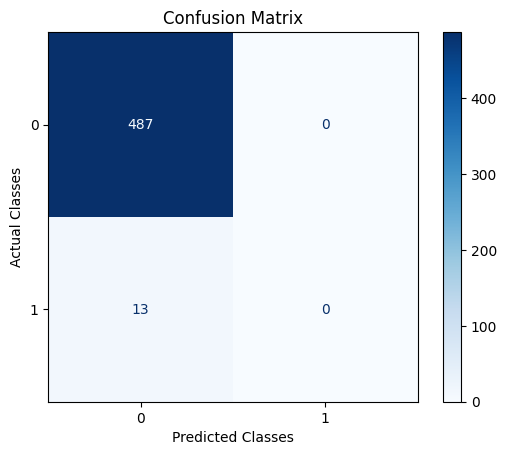

In [ ]:
predictions = torque_model.predict(x_single_test)
clean_y_single_test = []

for i in range(len(y_single_test)):
  clean_y_single_test.append(str(y_single_test[i]).replace("[", "").replace("]", ""))

cm1 = ConfusionMatrix(clean_y_single_test, predictions)

cm1.plot(cmap=plt.cm.Blues, number_label=True)

If you look at the 1 column of the Predicted label axis you can see two 0s in the squares. This tells us that our model never tried to predict a 1 in all 500 test sample predictions, confirming our theory. This caused us to miss all 13 machine failures that we can see in our confusion matrix. If we divide 13/500 that gives us 0.026, explaining why we got our 97.4% accuracy no matter what we chose for our X feature.

Luckily this is a common issue and `scikit-learn` already has a setting for our Logistic Regression model that should help. Keep in mind that I could probably do a whole session just on techniques to help with class imbalance and I'm only going to show the simplest on here for now.

Let's take another stab at our torque model. The setup below is mostly the same as before expect we are going to pass the `class_weight='balanced'` argument to our `LogisticRegression()` function. In a nutshell this will weight the importance of prediction differently for our two classes skewing the weighting to the underrepresented class. [Click here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) to view the documentation for this if you want to learn more. Essentially this should prevent the model from just predicting 0 all the time. From this we should expect a lower accuracy but we should be able to see some variety in the model's predictions.

Accuracy on test set: 0.704


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

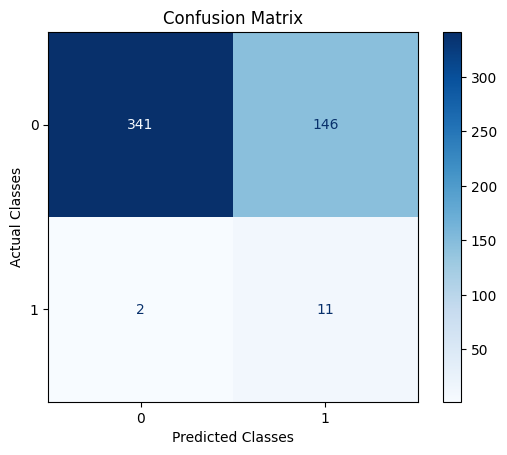

In [ ]:
# feel free to play with different features to use for X, ie perimeter_mean, compactness_mean, etc
x_single = processed_data['Torque [Nm]']

# some of this code comes from https://pythonspot.com/linear-regression/

x_single = x_single.values.reshape(len(x_single),1)

# Split the data into training/testing sets
x_single_train = x_single[:-500]
x_single_test = x_single[-500:]

# Create logistic regression object
torque_model_balanced = LogisticRegression(class_weight='balanced')

# Train the model using the training sets
torque_model_balanced.fit(x_single_train, y_single_train)
accuracy = torque_model_balanced.score(x_single_test, y_single_test)
print(f"Accuracy on test set: {accuracy:.3f}")

# format data for CM
clean_y_single_test2 = []

for i in range(len(y_single_test)):
  clean_y_single_test2.append(str(y_single_test[i]).replace("[", "").replace("]", ""))

# Confusion matrix
predictions = torque_model_balanced.predict(x_single_test)

cm2 = ConfusionMatrix(clean_y_single_test2, predictions)

cm2.plot(cmap=plt.cm.Blues, number_label=True)

Now we can see that our model is doing quite a bit worse accuracy-wise, but is at least making an attempt at predicting machine failures. This means we are training a model that's actually going to be useful to us rather than just always predicting 0. Now that we have a better starting point, let's see if we can increase our accuracy using some different model types.

###Decision Trees


There's only so far we can get in terms of accuracy with our model when all we have to work with is a straight line. Let's try a decision tree instead to see how that performs for our problem. Once again we are going to use the `class_weight='balanced'` argument to try to help with our class imbalance issue.

Accuracy on test set: 0.978


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

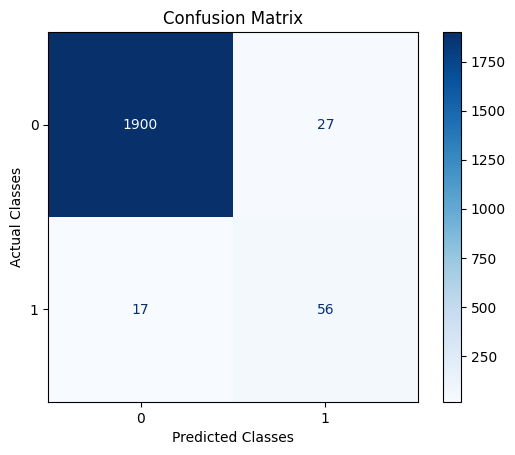

In [ ]:
x_tree = processed_data.drop('Machine failure', axis=1)
y_tree = processed_data['Machine failure']

x_train_tree, x_test_tree, y_train_tree, y_test_tree = train_test_split(x_tree, y_tree, test_size=0.2)

# create a classifier object
tree_model = DecisionTreeClassifier(class_weight='balanced')

# fit the classifier with X and Y data
tree_model.fit(x_train_tree, y_train_tree)

accuracy = tree_model.score(x_test_tree, y_test_tree)

print(f"Accuracy on test set: {accuracy:.3f}")

# Confusion matrix
predictions = tree_model.predict(x_test_tree)

cm3 = ConfusionMatrix(y_test_tree.tolist(), predictions)

cm3.plot(cmap=plt.cm.Blues, number_label=True)

Our accuracy is now ~98% which is much better than before. This isn't too surpring as the model now has a lot more information to work with rather than just one feature. We can also see in our confusion matrix that the model isn't just predicting 0.

---



###Random Forest


Now that we are starting to get some good results, let's see if we can do even better with some more complex techniques. What's better than one decision tree? What about a whole forest of decision trees? Run the code below to see what happens.

Accuracy on test set: 0.978


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

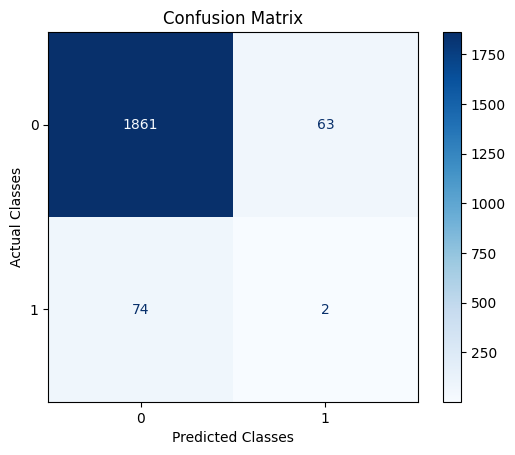

In [ ]:
x_forest = processed_data.drop('Machine failure', axis=1)
y_forest = processed_data['Machine failure']

x_train_forest, x_test_forest, y_train_forest, y_test_forest = train_test_split(x_forest, y_forest, test_size=0.2)

forest_model = RandomForestClassifier(class_weight='balanced')
forest_model.fit(x_train_forest, y_train_forest)

accuracy = forest_model.score(x_test_forest, y_test_forest)

print(f"Accuracy on test set: {accuracy:.3f}")

# Confusion matrix
predictions = forest_model.predict(x_test_tree)

cm4 = ConfusionMatrix(y_test_forest.tolist(), predictions)

cm4.plot(cmap=plt.cm.Blues, number_label=True)

The accuracy is pretty similar to the Decision Tree model. However, our confusion matrix tells us that we did not make very many/any correct machine failure predictions. This tells us that our Decision Tree model actually performed better despite the accuracies being similar. We could probably improve the Random Forest model by playing around with hyperparamaters and more dataset preprocessing but I'll leave that as an experiment for you.



---



###XGBoost

Now let's move away from bagging and try a boost ensemble model, in this case XGBoost. This is one of the most popular ML algorithms you'll come across in Kaggle competitions and other such sites. Below is the code needed to create your XGBoost model and fit it to your training data.

In [ ]:
# XGBoost doesn't like [] in the feature names so we need to change the names of our columns
processed_data = processed_data.rename(columns={"Air temperature [K]": "Air temperature",
                                                "Process temperature [K]": "Process temperature",
                                                "Rotational speed [rpm]": "Rotational speed",
                                                "Torque [Nm]": "Torque",
                                                "Tool wear [min]": "Tool wear"})

x_boost = processed_data.drop('Machine failure', axis=1)
y_boost = processed_data['Machine failure']

x_train_boost, x_test_boost, y_train_boost, y_test_boost = train_test_split(x_boost, y_boost, test_size=0.2)

boost = XGBClassifier()
boost.fit(x_train_boost, y_train_boost)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Now that our model is trained, let's see how it is doing on our data.

Accuracy on test set: 0.990


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

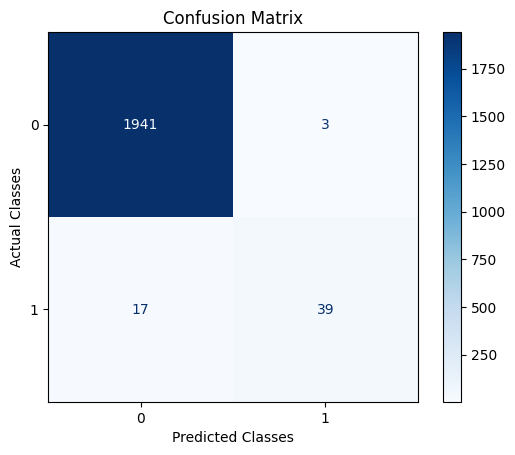

In [ ]:
accuracy = boost.score(x_test_boost, y_test_boost)
print(f"Accuracy on test set: {accuracy:.3f}")

# Confusion matrix
predictions = boost.predict(x_test_boost)

cm5 = ConfusionMatrix(y_test_boost.tolist(), predictions)

cm5.plot(cmap=plt.cm.Blues, number_label=True)

XGBoost seems to work pretty well on this problem. We have one of the highest accuracies we've seen yet and it is doing a good job on actually predicting machine failures.



---



###Conclusion

This wraps up our whirlwind tour of machine learning. Hopefully this gives you a good starting point to try using some of these algorithms for your own projects. Some last pieces of advice: take some time to get familiar with all they hyperparameters of the algorithm you are using. I didn't have the time to get into that for this session but scikit learn and XGBoost both have a ton of helpful options you can play with for their algorithms. Finally, don't get discouraged if you start a project and end up with a bunch of errors. Google search is your friend and a large part of getting better at ML projects, just like normal programming, is making mistakes and learning from them. Thanks for your time and happy coding!